## Test model DistillBert trên bộ dữ liệu SST-2 từ hugging face 

In [1]:

#  KIỂM THỬ MÔ HÌNH DISTILBERT TRÊN TOÀN BỘ SST-2
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import torch
import torch.nn.functional as F
import re, html, unicodedata
from tqdm import tqdm

# --- Làm sạch văn bản ---
def clean_text_bert(text):
    text = html.unescape(str(text))
    text = re.sub(r'<.*?>', ' ', text)
    text = unicodedata.normalize("NFKC", text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'([,.!?])\1+', r'\1', text)  # gộp dấu câu lặp
    text = text.lower()
    return text

# --- Load mô hình đã huấn luyện ---
model_path = "model-bert"  # thư mục chứa model đã train
tokenizer = DistilBertTokenizer.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# --- Load dữ liệu SST-2 ---
dataset = load_dataset("glue", "sst2")
test_data = dataset["validation"]
texts = test_data["sentence"]
labels = test_data["label"]

print(f"\n Tổng số mẫu validation SST-2: {len(labels)}")

# --- Làm sạch văn bản ---
texts_clean = [clean_text_bert(t) for t in texts]

# --- Dự đoán theo batch ---
batch_size = 32
preds, true_labels = [], []

for i in tqdm(range(0, len(texts_clean), batch_size), desc="Đang dự đoán với BERT"):
    batch_texts = texts_clean[i:i+batch_size]
    batch_labels = labels[i:i+batch_size]

    inputs = tokenizer(batch_texts, return_tensors='pt',
                       truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = F.softmax(logits, dim=-1)
        batch_preds = torch.argmax(probs, dim=1).cpu().numpy()

    preds.extend(batch_preds)
    true_labels.extend(batch_labels)

# --- Đánh giá ---
acc = accuracy_score(true_labels, preds)
print("\n KẾT QUẢ MÔ HÌNH DISTILBERT TRÊN TOÀN SST-2")
print("===========================================")
print(f" Độ chính xác (Accuracy): {acc:.4f}")
print("===========================================\n")
print("Báo cáo phân loại chi tiết:")
print(classification_report(true_labels, preds, digits=4))


c:\Users\nguye\Downloads\sentiment-analysis-svm-distilbert\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



 Tổng số mẫu validation SST-2: 872


Đang dự đoán với BERT: 100%|██████████| 28/28 [00:32<00:00,  1.15s/it]


 KẾT QUẢ MÔ HÌNH DISTILBERT TRÊN TOÀN SST-2
 Độ chính xác (Accuracy): 0.8567

Báo cáo phân loại chi tiết:
              precision    recall  f1-score   support

           0     0.8875    0.8107    0.8474       428
           1     0.8316    0.9009    0.8649       444

    accuracy                         0.8567       872
   macro avg     0.8595    0.8558    0.8561       872
weighted avg     0.8590    0.8567    0.8563       872



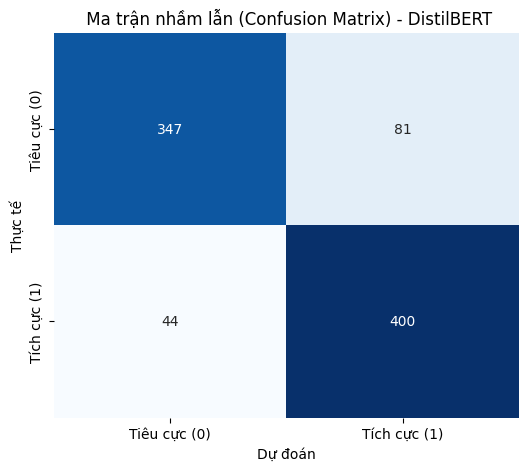

In [2]:
import matplotlib.pyplot as plt 
import seaborn as sns
# --- Ma trận nhầm lẫn ---
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Tiêu cực (0)', 'Tích cực (1)'],
            yticklabels=['Tiêu cực (0)', 'Tích cực (1)'])
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title(' Ma trận nhầm lẫn (Confusion Matrix) - DistilBERT')
plt.show()

## Test model SVM trên bộ dữ liệu SST-2 từ hugging face 

In [4]:
# KIỂM THỬ MÔ HÌNH SVM TRÊN SST-2
import joblib
import re, html, unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Chuẩn bị NLTK ---
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# --- Hàm làm sạch văn bản ---
def clean_text_svm(text):
    text = html.unescape(str(text))
    text = re.sub(r'<.*?>', ' ', text)
    text = text.lower()
    text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in STOPWORDS]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(tokens)

# --- Load mô hình và TF-IDF ---
svm_model = joblib.load("model-svm/svm_model.pkl")
tfidf = joblib.load("model-svm/tfidf_vectorizer.pkl")

# --- Load bộ dữ liệu SST-2 ---
dataset = load_dataset("glue", "sst2")
test_data = dataset["validation"]
texts_raw = test_data["sentence"]
labels = test_data["label"]

print(f"\nTổng số mẫu validation SST-2: {len(labels)}")

# --- Làm sạch và TF-IDF ---
texts_clean = [clean_text_svm(t) for t in texts_raw]
X_test = tfidf.transform(texts_clean)

# --- Dự đoán ---
y_pred = svm_model.predict(X_test)

# --- In từng kết quả ---
correct = 0
print("\nKẾT QUẢ DỰ ĐOÁN TRÊN SST-2:\n")
for i, (text, pred, true) in enumerate(zip(texts_raw, y_pred, labels)):
    label_pred = "Tích cực 😀" if pred == 1 else "Tiêu cực 😞"
    label_true = "Tích cực" if true == 1 else "Tiêu cực"
    correct += int(pred == true)
    print(f"{i+1:02d}. {text}")
    print(f"→ Dự đoán: {label_pred} | Thật: {label_true}\n")

# --- Tổng kết ---
acc = correct / len(labels)
print("===========================================")
print(f"Độ chính xác (Accuracy): {acc:.4f}")
print("===========================================\n")




Tổng số mẫu validation SST-2: 872

KẾT QUẢ DỰ ĐOÁN TRÊN SST-2:

01. it 's a charming and often affecting journey . 
→ Dự đoán: Tích cực 😀 | Thật: Tích cực

02. unflinchingly bleak and desperate 
→ Dự đoán: Tích cực 😀 | Thật: Tiêu cực

03. allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker . 
→ Dự đoán: Tích cực 😀 | Thật: Tích cực

04. the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales . 
→ Dự đoán: Tiêu cực 😞 | Thật: Tích cực

05. it 's slow -- very , very slow . 
→ Dự đoán: Tiêu cực 😞 | Thật: Tiêu cực

06. although laced with humor and a few fanciful touches , the film is a refreshingly serious look at young women . 
→ Dự đoán: Tích cực 😀 | Thật: Tích cực

07. a sometimes tedious film . 
→ Dự đoán: Tiêu cực 😞 | Thật: Tiêu cực

08. or doing last year 's taxes with your ex-wife . 
→ Dự đoán: Tích cực 😀 | Thật: Tiêu cực

09. you do n't have to know about music to appreci

In [5]:
# --- Báo cáo chi tiết ---
print("Báo cáo phân loại:")
print(classification_report(labels, y_pred, digits=4))

Báo cáo phân loại:
              precision    recall  f1-score   support

           0     0.7186    0.7220    0.7203       428
           1     0.7308    0.7275    0.7291       444

    accuracy                         0.7248       872
   macro avg     0.7247    0.7247    0.7247       872
weighted avg     0.7248    0.7248    0.7248       872



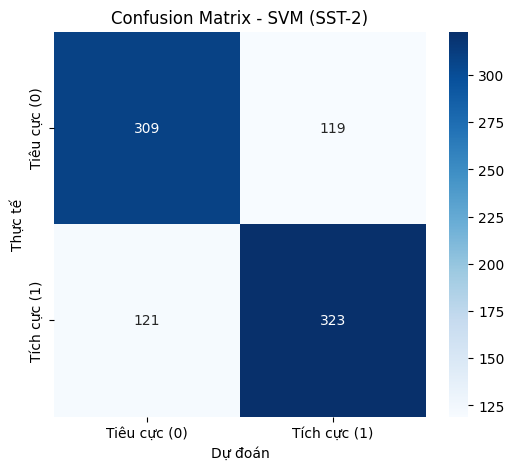

In [6]:
# --- Ma trận nhầm lẫn ---
cm = confusion_matrix(labels, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Tiêu cực (0)', 'Tích cực (1)'],
            yticklabels=['Tiêu cực (0)', 'Tích cực (1)'])
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Confusion Matrix - SVM (SST-2)')
plt.show()